In [1]:
from __future__ import print_function
from copy import deepcopy
from scipy.io.wavfile import read as wavread
import scipy.signal as signal
from numpy.linalg import norm
import librosa, os, numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from myutils import *

In [2]:
old_data = []
data = []
srs = []
offsets = []
onset_times = []

def getwindow(center, windowsize):
    if type(windowsize) is int:
        return np.arange(center-windowsize, center+windowsize)
    else:
        return np.arange(center+windowsize[0], center+windowsize[1])
    
def tts(t, sr=44100):
        return [int(ts*sr) for ts in t]  if isinstance(t, (tuple, list)) else int(t*sr)

def stt(sample, sr=44100):
    return [s/float(sr) for s in sample] if isinstance(sample, (tuple, list)) else sample/float(sr) 

def newfig(w=40,h=40, **kwargs):
    return plt.figure(figsize=(w,h),**kwargs)

def loadfiles(path="./data/1_aligned", clip_intro=0):
    global data, old_data, srs, offsets, onset_times
    data = []
    srs = []
    offsets = []
    onset_times = []
    datadir = os.path.abspath(path)
    print("Using recordings from %s" % (datadir))
    
    data=[]
    srs=[]
    for file in os.listdir(datadir):
        if file.endswith('.wav'):
            (sr,dat) = wavread(os.path.join(datadir,file))
            if len(dat.shape) > 1:
                dat = dat[:,0]
            if clip_intro > 0:
                dat = dat[tts(clip_intro):]
            dat = dat.astype(np.float32)/np.max(dat)
            data.append(dat)
            srs.append(sr)
            onset_times.append(librosa.onset.onset_detect(dat,units="samples",sr=sr, backtrack=False))
            offsets.append(0)
            print("loaded %s" % file)
    old_data=[np.copy(dat) for dat in data]

datafolder = os.path.abspath("./data")
options = {run:os.path.join(datafolder,run) for run in os.listdir(datafolder) if os.path.isdir(os.path.join(datafolder,run)) }
loader=interactive(loadfiles,path=options, clip_intro=(0,65,0.5)) 
display(loader)

interactive(children=(Dropdown(description='path', options={'.ipynb_checkpoints': 'E:\\Dev\\acoustic-localizat…

In [3]:
def onset_ex(which=0,windowsize=1.0, center=1.0, back_track=False):
    global onset_times
    ww = getwindow(tts(center),tts(windowsize))
    clip = data[which][ww]
    onsets = librosa.onset.onset_detect(np.asfortranarray(data[which]),units="samples",sr=srs[which],
                                             backtrack=back_track)
    print("plot centered at %f (%d, %d to %d)" %
          (center,tts(center),tts(center-windowsize), tts(center+windowsize)))
    plt.plot(np.linspace(stt(ww[0]), stt(ww[-1]), len(clip)),clip)
    ost_in_window = onsets[np.logical_and(onsets >= ww[0], onsets <= ww[-1])]
    plt.vlines(stt(ost_in_window), -1,1, 'r')
    plt.ylim(-1,1)
    print("avg onset rate is %fHz" % (1/stt(np.mean(np.diff(ost_in_window)))))
#     onset_times = ost_in_window

options = {b:a for a,b in enumerate([str(a) for a in np.arange(1,len(data)+1)])}
onset_example = interactive(onset_ex, {'manual':False}, which=options,
                            windowsize=(.1,10,.05),
                            center=(0.250,stt(min([len(a) for a in data])), 0.050),
                            back_track=False)
sl1 = onset_example.children[1]
sl2 = onset_example.children[2]
sl2.continuous_update=False
def update_center_slider(*args):
    sl2.min = max(sl2.value-3*sl1.value, sl1.value)
    sl2.max = sl2.value+3*sl1.value
sl2.observe(update_center_slider, 'value')
sl1.observe(update_center_slider, 'value')
onset_example

interactive(children=(Dropdown(description='which', options={'1': 0, '2': 1, '3': 2, '4': 3}, value=0), FloatS…

In [4]:
def filt(wl=10, wh= 500, typ='bandstop', order=5, which=0, sz=0.5):
    global data, old_data
#     data = [np.copy(dat) for dat in old_data]
    wl *=2*np.pi
    wh *=2*np.pi
    windw = getwindow(int(np.mean(onset_times[0][2:10])), tts(sz))
    sig = data[which][windw]
    newfig(h=5)   
    plt.plot(stt(windw) - offsets[which],sig,color='black')
    plt.xlim([stt(windw[0]), stt(windw[-1])])
    plt.ylim([-0.1, 0.1])
    if typ=='none':
        return
    elif typ=='highpass':
        b, a = signal.butter(order, wh, btype=typ, fs=44100)
    elif typ=='lowpass':
        b, a = signal.butter(order, wl, btype=typ, fs=44100)
    else:
        b, a = signal.butter(order, (wl,wh), btype=typ, fs=44100)

    fsig = signal.filtfilt(b,a,sig)
    fsig*=np.max(sig)/np.max(fsig)
    
    plt.plot(stt(windw) - offsets[which],fsig,color='darkorange')


wnl = widgets.FloatLogSlider(
    value=10,
    base=10,
    min=0,
    max=4,
    step=0.1,
    description='low freq:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f')
order = widgets.IntSlider(
    value=3,
    min=0,
    max=10,
    step=1,
    description='filter order:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f')
wnh = widgets.FloatLogSlider(
    value=500,
    base=10,
    min=2,
    max=np.log(44100)/2,
    step=0.1,
    description='high freq:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
wndsz = widgets.FloatLogSlider(
    value=0.25,
    base=10,
    min=-2,
    max=3,
    step=0.05,
    description='window width:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
filt_butt = widgets.ToggleButtons(
    options = ['lowpass', 'highpass', 'bandpass', 'bandstop', 'none'],
    value='bandstop',
    description='filter type:',
    disabled=False,)
sig_select = widgets.Dropdown(
    options={b:a for a,b in enumerate([str(a) for a in np.arange(1,len(data)+1)])},
    value=0,
    description='Refernce wav:',
    disabled=False)
filterbtn = widgets.Button(
    description='filter all',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='save filter settings',
    icon='check')

def filter_all(*args):
    global data, old_data, onset_times
    data = [np.copy(dat) for dat in old_data]
    wl = wnl.value*2*np.pi
    wh = wnh.value*2*np.pi
    typ=filt_butt.value
    ordr = order.value
    if typ=='none':
        return
    elif typ=='highpass':
        b, a = signal.butter(ordr, wh, btype=typ, fs=44100)
    elif typ=='lowpass':
        b, a = signal.butter(ordr, wl, btype=typ, fs=44100)
    else:
        b, a = signal.butter(ordr, (wl,wh), btype=typ, fs=44100)
    
    for d in range(len(data)):
        data[d] = signal.filtfilt(b,a,data[d])
        data[d]*=np.max(old_data[d])/np.max(data[d])
#         onset_times[d] = librosa.onset.onset_detect(data[d],units="samples",sr=sr, backtrack=False)

filterbtn.on_click(filter_all)
options = ['lowpass', 'highpass', 'bandpass', 'bandstop']
filtex = widgets.interactive_output(filt,{'wl':wnl, 'wh':wnh, 'typ':filt_butt, 'order':order, 'which':sig_select, 'sz':wndsz})
display(widgets.VBox([widgets.HBox([filt_butt, sig_select,filterbtn]), widgets.HBox([wnl,wnh, order, wndsz])]),filtex)

#best filter so far has been highpass 650Hz

Output()

In [5]:
ref = 0
x_ax_align = []
y_ax_align = []
offsets= [0 for k in offsets] 
def do_settings_align(reference, lns, wrl, wrh, yr, oc, pr, **kwargs):
    global ref, lines, scale, x_ax_align, y_ax_align
    ref = reference
    x_ax_align = [wrl, wrh]
    y_ax_align = yr
    plot(oc,pr,lns,x_ax_align, y_ax_align, reference)

def plot(plot_onsets=True, plot_ref=True, lines = [], x_ax = x_ax_align, y_ax=y_ax_align,ref=0, **kwargs):
    ww = np.arange(tts(x_ax[0]), tts(x_ax[1]))
    f = plt.figure(figsize = (40,10))
    rc = np.ceil(np.sqrt(len(data)))
    for ln in lines:
        plt.subplot(rc,rc,ln+1)
        ofs = tts(offsets[ln])
        clip = data[ln][ww+ofs]
        plt.plot(np.linspace(stt(ww[0]),stt(ww[-1]),len(clip)),clip)
        if plot_onsets:
            plt.vlines(stt(onset_times[ref]), -1, 1, 'r')
        if plot_ref:
            rr = data[ref][ww + tts(offsets[ref])] 
            plt.plot(np.linspace(stt(ww[0]),stt(ww[-1]),len(rr)),rr, 'k', alpha=0.7)
        plt.xlim(x_ax)
        plt.ylim(y_ax)

ref_select = widgets.Dropdown(
    options={b:a for a,b in enumerate([str(a) for a in np.arange(1,len(data)+1)])},
    value=0,
    description='Refernce wav:',
    disabled=False)
lines_select = widgets.SelectMultiple(
    options={b:a for a,b in enumerate([str(a) for a in np.arange(1,len(data)+1)])},
    value=[0],
    description='Wavs to plot',
    disabled=False)
w_range_low = widgets.FloatSlider(
    value=0,
    min=0,
    max=stt(len(data[0])),
    step=0.001,
    description='Lower Bound:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
w_range_high = widgets.FloatSlider(
    value=stt(len(data[0])),
    min=0,
    max=stt(len(data[0])),
    step=0.001,
    description='Upper Bound:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
scale_buttons = widgets.ToggleButtons(
    options=['full','coarse', 'med', 'fine', 'ultrafine'],
    value='full',
    description='scrub speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['1','2','3'])
y_range = widgets.FloatRangeSlider(
    value=[-1, 1],
    min=-1,
    max=1,
    step=0.05,
    description='Vertical range:',
    disabled=False,
    continuous_update=True,
    orientation='vertical',
    readout=True,
    readout_format='.4f')
onset_cb = widgets.Checkbox(
    value=True,
    description='Plot Onsets',
    disabled=False,
    indent=False)
overlay_cb = widgets.Checkbox(
    value=True,
    description='Plot Ref',
    disabled=False,
    indent=False)
replot_button = widgets.ToggleButton(
    value=False,
    description='replot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def update_range_low(*args):
    if scale_buttons.value == scale_buttons.options[0]:
        w_range_low.min = 0
        w_range_low.max = min(stt(len(data[ref])), w_range_high.value)
    elif scale_buttons.value == scale_buttons.options[1]:
        scl = 15
        w_range_low.min = max(0,w_range_low.value-scl)
        w_range_low.max = min(w_range_low.value+scl, w_range_high.value)
    elif scale_buttons.value == scale_buttons.options[2]:
        scl = 5
        w_range_low.min = max(0,w_range_low.value-scl)
        w_range_low.max = min(w_range_low.value+scl, w_range_high.value)
    elif scale_buttons.value == scale_buttons.options[3]:
        scl = 0.25
        w_range_low.min = max(0,w_range_low.value-scl)
        w_range_low.max = min(w_range_low.value+scl, w_range_high.value)
    elif scale_buttons.value == scale_buttons.options[4]:
        scl = 0.01
        w_range_low.min = max(0,w_range_low.value-scl)
        w_range_low.max = min(w_range_low.value+scl, w_range_high.value)
        
def update_range_high(*args):
    if scale_buttons.value == scale_buttons.options[0]:
        w_range_high.min = max(0,stt(w_range_low.value))
        w_range_high.max = stt(len(data[ref]))
    elif scale_buttons.value == scale_buttons.options[1]:
        scl = 15
        w_range_high.min = max(w_range_high.value-scl, w_range_low.value)
        w_range_high.max = min(w_range_high.value+scl, stt(len(data[ref])))
    elif scale_buttons.value == scale_buttons.options[2]:
        scl = 5
        w_range_high.min = max(w_range_high.value-scl, w_range_low.value)
        w_range_high.max = min(w_range_high.value+scl, stt(len(data[ref])))
    elif scale_buttons.value == scale_buttons.options[3]:
        scl = 0.25
        w_range_high.min = max(w_range_high.value-scl, w_range_low.value)
        w_range_high.max = min(w_range_high.value+scl, stt(len(data[ref])))
    elif scale_buttons.value == scale_buttons.options[4]:
        scl = 0.01
        w_range_high.min = max(w_range_high.value-scl, w_range_low.value)
        w_range_high.max = min(w_range_high.value+scl, stt(len(data[ref])))

def update_wrange(*args):
    update_range_low()
    update_range_high()
    
lb = widgets.VBox([ref_select, lines_select])
rb = widgets.VBox([w_range_low,w_range_high, onset_cb, overlay_cb, replot_button])
# rb.layout.width = '50%'
y_range.layout.width='100px'
ui = widgets.HBox([lb, rb, y_range, scale_buttons])
ui.layout.width='100%'
out = widgets.interactive_output(do_settings_align, {'reference':ref_select,
                                               'lns':lines_select,
                                               'wrl':w_range_low,
                                               'wrh':w_range_high,
                                               'yr':y_range,
                                               'oc':onset_cb,
                                               'pr':overlay_cb,
                                               'rp':replot_button
                                              })

scale_buttons.observe(update_wrange, 'value')
w_range_low.observe(update_range_high, 'value')
w_range_high.observe(update_range_low, 'value')

display(ui,out)

Output()

In [6]:

offs = widgets.VBox([widgets.FloatSlider(value=offsets[k], min=-0.1, max=0.1, step=0.00001, readout_format='.5f', description="offset %d"%(k+1), continuous_update=True) for k in range(len(data))])
scale_buttons2 = widgets.ToggleButtons(
    options=['coarse', 'med', 'fine', 'ultrafine'],
    value='med',
    description='scrub speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['1','2','3'])
replot_button2 = widgets.ToggleButton(
    value=False,
    description='replot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
def set_ranges(*args):
    for ix, slider in enumerate(offs.children):
        if scale_buttons2.value == scale_buttons2.options[0]:
            scl = 0.5
            slider.min = slider.value-scl
            slider.max = slider.value+scl
        elif scale_buttons2.value == scale_buttons2.options[1]:
            scl = 0.1
            slider.min = slider.value-scl
            slider.max = slider.value+scl
        elif scale_buttons2.value == scale_buttons2.options[2]:
            scl = 0.01
            slider.min = slider.value-scl
            slider.max = slider.value+scl
        elif scale_buttons2.value == scale_buttons2.options[3]:
            scl = 0.001
            slider.min = slider.value-scl
            slider.max = slider.value+scl

def update_offsets(*args):
    global offsets
    for ix, slider in enumerate(offs.children):
        offsets[ix] = slider.value

def replot(**kwargs):
    update_offsets()
    plot(x_ax=x_ax_align, y_ax=y_ax_align, ref=ref,**kwargs)
    
d_map = {str(k):offs.children[k] for k in range(len(offs.children))}
d_map.update({'plot_onsets':fixed(True), 'plot_ref':fixed(True), 'lines':fixed([ix for ix in range(len(data))]), 'x':replot_button2})
out2 = widgets.interactive_output(replot, d_map)
scale_buttons2.observe(set_ranges,'value')
hb = widgets.HBox([offs, widgets.VBox([scale_buttons2, replot_button2])])
display(hb, out2)

Output()

In [7]:
#cross correlate signals

#at each onset, take window (variable) around onset and correlate samples
temp_offsets = []
def corr_ex(window):
    global temp_offsets
    temp_offsets = [0 for k in offsets]
    print(tts(window), len(tts(window)))
    ref_clip = data[ref] 
    onsets = onset_times[ref]
    onsets = onsets[np.logical_and(onsets >= tts(x_ax_align[0]), onsets <= tts(x_ax_align[1]))]
    numonsets = len(onsets)
    f = plt.figure(figsize = (18,16))
    rc = np.ceil(np.sqrt(len(data)))
    
    for b in range(len(data)):
        delays = np.zeros((numonsets))
        corrs = np.zeros((numonsets))
        delay = 0
        prev_corr = 0
        for ix, onset in enumerate(onsets):
            ref_w = getwindow(onset, tts(0.25))
            ref_clip = data[ref][ref_w]
            b_peak = np.argmax(np.abs(data[b][ref_w]))
            wb = getwindow(onset+tts(offsets[b]), tts(window))
            b_clip = data[b][wb] 
            corr=np.correlate(np.abs(ref_clip),np.abs(b_clip), mode="valid")
            prev_corr = corr/numonsets + prev_corr
            mx = np.argmax(corr)
            delays[ix] = stt(len(corr)/2 - mx)
            delay+=stt(len(corr)/2 - mx)/numonsets
    
#     for ix in range(len(data)):
# #         corr = np.zeros((tts(window[1]-window[0]),))
#         delays = np.zeros((numonsets))
#         corrs = np.zeros((numonsets))
#         delay = 0
#         prev_corr = 0
#         for j, onset in enumerate(onsets):
#             ref_w = getwindow(onset, tts(0.25))
#             ww = getwindow(onset, tts(window))
#             ref_clip = data[ref][ref_w]
#             c1 = np.correlate(np.abs(ref_clip),np.abs(data[ix][ww+tts(offsets[ix])])*np.max(np.abs(ref_clip))/np.max(np.abs(data[ix][ww+tts(offsets[ix])])), mode="valid")
#             corr=c1/numonsets + prev_corr
#             prev_corr = corr
#             delays[j] = stt(len(corr)/2 - np.argmax(c1))
#             delay+= stt(len(corr)/2 - np.argmax(c1))/numonsets
        plt.subplot(rc,rc,b+1)
        plt.plot(corr)
        plt.vlines(np.argmax(corr),np.min(corr),corr[np.argmax(corr)],'r')
        print("delay between %d and %d (ref) is %0.5f, with stdev %.3fe-3" % (b,ref, delay, np.std(delays)*1e3))
        print
        temp_offsets[b]+=delay
    

    
window_range = widgets.FloatRangeSlider(
    value=[-0.1, 0.1],
    min=-0.25,
    max=0.25,
    step=0.05,
    description='Window range:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')

update_btn = widgets.Button(
    description='update offsets',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check')

out3 = widgets.interactive_output(corr_ex, {'window':window_range})
def update_button(*args):
    global offsets, temp_offsets, offs, out3, out2
    corr_ex(window_range.value)
    local_offsets = offsets
    for ix, slider in enumerate(offs.children):
        local_offsets[ix] += temp_offsets[ix]
        slider.value = local_offsets[ix]
    offsets=local_offsets
    out3.clear_output()
    out2.clear_output(wait=True)
    with out3:
        print('updated:')
        corr_ex(window_range.value)
        plt.show()
    with out2:
        plot(True,True,[ix for ix in range(len(data))],x_ax_align, y_ax_align, ref)
        plt.show()
display(window_range,update_btn, out3)
update_btn.on_click(update_button)

FloatRangeSlider(value=(-0.1, 0.1), description='Window range:', max=0.25, min=-0.25, readout_format='.4f', st…

Button(description='update offsets', icon='check', style=ButtonStyle(), tooltip='Click me')

Output()

In [23]:
print("Offsets (ms): %.2f, %.2f, %.2f, %.2f" % tuple([o*1e3 for o in offsets]))
print("Offsets (samples)", tts(offsets))
print("'Error' (ms): %.2f, %.2f, %.2f, %.2f" % tuple([to*1000 for to in temp_offsets]))

Offsets (ms): -93.35, -41.42, -26.69, 0.01
Offsets (samples) [-4116, -1826, -1177, 0]
'Error' (ms): -0.01, 0.00, 0.01, 0.01


In [8]:
off_data = []
for k in range(len(data)):
    off_data.append(data[k][tts(offsets[k]):])

In [9]:
x_ax_tdoa = []
y_ax_tdoa= []
maxx = stt(min([len(data[k]) - tts(offsets[k]) for k in range(len(data))]))-1
def do_settings_tdoa(reference, lns, wrl, wrh, yr, oc, pr, **kwargs):
    global lines, scale, x_ax_tdoa, y_ax_tdoa
    x_ax_tdoa = [wrl, wrh]
    y_ax_tdoa = yr
    plot(oc,pr,lns, x_ax_tdoa, y_ax_tdoa)

w_range_low2 = widgets.FloatSlider(
    value=0,
    min=0,
    max=maxx,
    step=0.001,
    description='Lower Bound:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
w_range_high2 = widgets.FloatSlider(
    value=maxx,
    min=0,
    max=maxx,
    step=0.001,
    description='Upper Bound:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f')
scale_buttons3 = widgets.ToggleButtons(
    options=['full','coarse', 'med', 'fine', 'ultrafine'],
    value='full',
    description='scrub speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['1','2','3'])
y_range2 = widgets.FloatRangeSlider(
    value=[-1, 1],
    min=-1,
    max=1,
    step=0.05,
    description='Vertical range:',
    disabled=False,
    continuous_update=True,
    orientation='vertical',
    readout=True,
    readout_format='.4f')
onset_cb2 = widgets.Checkbox(
    value=True,
    description='Plot Onsets',
    disabled=False,
    indent=False)

replot_button2 = widgets.ToggleButton(
    value=False,
    description='replot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def update_range_low2(*args):
    if scale_buttons3.value == scale_buttons3.options[0]:
        w_range_low2.min = 0
        w_range_low2.max = min(maxx, w_range_high2.value)
    elif scale_buttons3.value == scale_buttons3.options[1]:
        scl = 15
        w_range_low2.min = max(0,w_range_low2.value-scl)
        w_range_low2.max = min(w_range_low2.value+scl, w_range_high2.value)
    elif scale_buttons3.value == scale_buttons3.options[2]:
        scl = 5
        w_range_low2.min = max(0,w_range_low2.value-scl)
        w_range_low2.max = min(w_range_low2.value+scl, w_range_high2.value)
    elif scale_buttons3.value == scale_buttons3.options[3]:
        scl = 0.25
        w_range_low2.min = max(0,w_range_low2.value-scl)
        w_range_low2.max = min(w_range_low2.value+scl, w_range_high2.value)
    elif scale_buttons3.value == scale_buttons3.options[4]:
        scl = 0.01
        w_range_low2.min = max(0,w_range_low2.value-scl)
        w_range_low2.max = min(w_range_low2.value+scl, w_range_high2.value)
        
def update_range_high2(*args):
    if scale_buttons3.value == scale_buttons3.options[0]:
        w_range_high2.min = max(0,w_range_low2.value)
        w_range_high2.max = maxx
    elif scale_buttons3.value == scale_buttons3.options[1]:
        scl = 15
        w_range_high2.min = max(w_range_high2.value-scl, w_range_low.value)
        w_range_high2.max = min(w_range_high2.value+scl, maxx)
    elif scale_buttons3.value == scale_buttons3.options[2]:
        scl = 5
        w_range_high2.min = max(w_range_high2.value-scl, w_range_low2.value)
        w_range_high2.max = min(w_range_high2.value+scl, maxx)
    elif scale_buttons3.value == scale_buttons3.options[3]:
        scl = 0.25
        w_range_high2.min = max(w_range_high2.value-scl, w_range_low2.value)
        w_range_high2.max = min(w_range_high2.value+scl, maxx)
    elif scale_buttons3.value == scale_buttons3.options[4]:
        scl = 0.01
        w_range_high2.min = max(w_range_high2.value-scl, w_range_low2.value)
        w_range_high2.max = min(w_range_high2.value+scl, maxx)

def update_wrange2(*args):
    update_range_low2()
    update_range_high2()
    
rb2 = widgets.VBox([w_range_low2,w_range_high2, onset_cb2, replot_button2])
# rb.layout.width = '50%'
y_range2.layout.width='100px'
ui2 = widgets.HBox([rb2, y_range2, scale_buttons3])
ui2.layout.width='100%'
out4 = widgets.interactive_output(do_settings_tdoa, {'reference':fixed(ref),
                                               'lns':fixed([k for k in range(len(data))]),
                                               'wrl':w_range_low2,
                                               'wrh':w_range_high2,
                                               'yr':y_range2,
                                               'oc':onset_cb2,
                                               'pr':fixed(False),
                                               'rp':replot_button2
                                              })

scale_buttons3.observe(update_wrange2, 'value')
w_range_low2.observe(update_range_high2, 'value')
w_range_high2.observe(update_range_low2, 'value')

display(ui2,out4)

Output()

In [10]:
#update onsets to only this window
# unique_onsets = np.array([])
for d in range(len(data)):
    onset_times[d] = librosa.onset.onset_detect(np.asfortranarray(off_data[d]),units="samples",sr=44100, backtrack=False)
#     unique_onsets = np.append(unique_onsets, onset_times[d])
ror = onset_times[ref]
ror = ror[np.logical_and(stt(ror)>x_ax_tdoa[0], stt(ror)<x_ax_tdoa[1])]
for ix in range(len(ror)-1):
    dt = ror[ix+1]-ror[ix]
    if dt > 0.4:
        ror = np.insert(ror, ix+1, ror[ix]+tts(0.25))
# unique_onsets = np.unique(unique_onsets)

In [76]:
ref = 0
delays = []
times = []
corr_score = []
uncert = []
medians = []
# out5 = widgets.Output()
# def update_window(*args):
#     global window
#     chg = args[0]
#     window=[-chg.new, chg.new]
#     out5.clear_output()
#     with out5:
#         getdts(window)
#         print("cool")
#         plt.show()

def getdts(window):
    global times, delays, uncert, corr_score, medians, onset_times, x_ax_tdoa
    onsets = onset_times[ref]
#     onsets = ror
    onsets_in_window = onsets[np.logical_and(onsets >= tts(x_ax_tdoa[0]), onsets <= tts(x_ax_tdoa[1]))]
    delays = np.zeros((len(onsets_in_window),len(onset_times)), dtype=np.float64)
    times = np.zeros((len(onsets_in_window),len(onset_times)),dtype=np.float64)
    dts = np.zeros((len(onsets_in_window),len(onset_times),len(onset_times)),dtype=np.float64)
    corr_score = np.zeros((len(onsets_in_window),len(onset_times),len(onset_times)))
    uncert = np.zeros((len(onsets_in_window),len(onset_times)))
#     medians = np.zeros((len(onsets_in_window),len(onset_times)))
    time = stt(onsets_in_window)

#     for ix, onset in enumerate(onsets_in_window):
#         ref_w = getwindow(onset, tts(0.2))
#         for mic in range(len(data)):
#             b_peak= np.argmax(np.abs(off_data[mic][ref_w])) - tts(0.2)
#             wb = getwindow(onset+b_peak, tts(window))
#             b_clip = off_data[mic][wb] 
# #             r = 0
#             for r in range(len(data)):
#                 ref_clip = off_data[r][ref_w]
#                 corr=np.correlate(np.abs(ref_clip),np.abs(b_clip), mode="valid")
#                 mx = np.argmax(corr)
#                 dts[ix,mic,r] = stt(len(corr)/2 - mx) + stt(b_peak)
# #                 print(stt(len(corr)/2 - mx) + stt(b_peak))
#         #             corr_score[ix,d] = np.max(corr)
#         #             uncert[ix,d] = np.std(corr)
#         #             medians[ix,d] = np.median(corr)    
#             times[ix,mic] = np.mean(dts[ix,mic]) + stt(onset)
#             delays[ix,mic] = np.mean(dts[ix,mic])
#             uncert[ix,mic] = np.std(dts[ix,mic] + stt(onset))
# #         delays[ix] = times[ix] - times[ix,0]


    for ix, onset in enumerate(onsets_in_window):
        ref_w = getwindow(onset, tts(0.2))
        for r in range(len(data)):
            ref_clip = off_data[r][ref_w]
            for b in range(len(data)):
                b_peak= np.argmax(np.abs(off_data[b][ref_w])) - tts(0.2)
                wb = getwindow(onset+b_peak, tts(window))
                b_clip = off_data[b][wb] 
                corr=np.correlate(np.abs(ref_clip),np.abs(b_clip), mode="valid")
                mx = np.argmax(corr)
                dts[ix,r,b] = stt(mx - tts(0.2))
                
            times[ix,r] = np.mean(dts[ix,r]) + stt(onset)
            delays[ix,r] = np.mean(dts[ix,r])
            uncert[ix,r] = norm((np.std(dts[ix,r] + stt(onset)), 1e-5))
        
    
getdts([-0.1,0.1])

<Figure size 720x360 with 0 Axes>

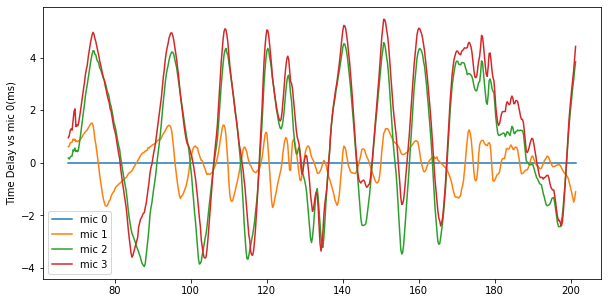

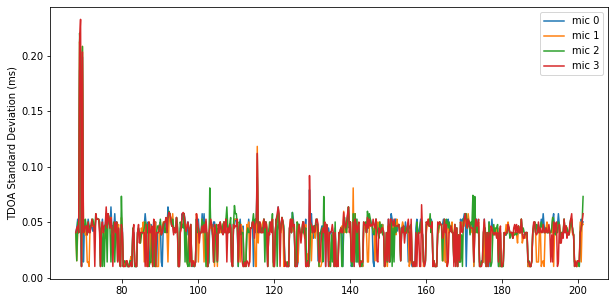

In [77]:
#plot the results
def plotarray(arr, skipref=False, logscale=False, ylabel=''):
    newfig(h=5,w=10)
    for k in range(arr.shape[1]):
#         if k==ref and skipref:
#             continue
        ln, = plt.plot(times[:,0],arr[:,k])
        plt.yscale('log' if logscale else 'linear')
        label = "mic " + str(k)
        ln.set_label(label)
    plt.ylabel(ylabel)
    plt.legend()


newfig(h=5,w=10)
rc = np.ceil(np.sqrt(len(data)))
# t = delays[:,0]
# dts = np.zeros(delays.shape)
# for m in range(len(data)):
#     dts[:,m] = delays[:,m] - delays[:,0]
# for d in range(len(data)):
#     plt.subplot(rc,rc,d+1)
#     plt.plot(delays[:,ref],corr_score[:,d],'r',label='correlation')
#     plt.plot(delays[:,ref],medians[:,d]+uncert[:,d],'.k',label='+stdev')
#     plt.plot(delays[:,ref],medians[:,d]-uncert[:,d],'.k',label='-stdev')
#     plt.plot(delays[:,ref],medians[:,d],'.b',label='median')
# plt.show()
newdelays = np.zeros(delays.shape)
for a in range(len(data)):
    newdelays[:,a] = delays[:,a] - delays[:,0]
plotarray(newdelays*1e3, skipref=True, ylabel="Time Delay vs mic 0(ms)")
# yl = np.mean(delays[:,np.arange(len(data))!=ref]) + np.std(delays[:,np.arange(len(data))!=ref])*np.array([-2.5,2.5])
# print(yl)
# plt.ylim(yl)
plt.show()
plotarray(uncert*1e3, ylabel="TDOA Standard Deviation (ms)")
# plt.show()


In [78]:
def tdoa(pos, mics):
    dt = (norm(pos-mics[1])-norm(pos-mics[0]))/343
    return dt

def get_err(pos,mics,ts):
    #mics in list by position (x,y)
    #ts is time signal hit each mic
    errs = np.array([])
#     print(pos)
    for i in range(len(mics)-1):
        for j in range(i+1,len(mics)):
            dt_meas = ts[j]-ts[i]
            dt_calc = tdoa(pos,(mics[i],mics[j]))
            errs = np.append(errs,dt_meas-dt_calc)
    return errs*1000

def solve(mics,ts, guess = [0.5,0.5]):
    solution = lsq(get_err,guess,'3-point', kwargs={'mics':mics,'ts':ts})
    return solution

In [79]:
w = 65.5*.0254
h = 30.5*.0254
t_uncert = 1e-4
mmics = ([0,h],[0,0],[w,h],[w,0])
# anss = np.zeros((delays.shape[0],3))
time = times[:,0]
# angles = np.zeros((delays.shape[0],))
poses = np.zeros((delays.shape[0],2))
posuncert = np.zeros((delays.shape[0],2))
uninformed_guess = [0, 0]
prev_good = 0

for k in range(times.shape[0]):
    guess = uninformed_guess if not prev_good else poses[k-1]
    ans = solve(mmics,times[k],guess)
    poses[k] = ans.x
    unc = np.array([])
    for i in range(len(mmics)-1):
        for j in range(i+1,len(mmics)):
            unc = np.append(unc,norm((uncert[k,i],uncert[k,j])))
    xunc = norm(ans.jac[:,0]*unc)
    yunc = norm(ans.jac[:,1]*unc)
    posuncert[k] = np.array([xunc,yunc])
#     anss[k] = ans

In [147]:
h = 65.5*.0254
w = 30.5*.0254
mmics = np.array([[0,0],[w,0],[0,h],[w,h]])
mics = []
for i in range(len(mmics)):
    if i==ref:
        continue
    pos = mmics[i]-mmics[ref]
    mics.append(pol(pos[0],pos[1]))
anss = np.zeros((delays.shape[0],3))
time = delays[:,ref]
angles = np.zeros((delays.shape[0],))
poses = np.zeros((delays.shape[0],2))
gpos = np.mean([cart(m[0],m[1]) for m in mics], 0)
uninformed_guess = [pol(gpos[0], gpos[1])[1]]*3
prev_good = 0
for ix in range(delays.shape[0]):
    dts = delays[ix,np.arange(delays.shape[1])!=ref]
#     guess = [np.radians(15)]*3 if ix==0 else [angles[ix-1]]*3
#     guess = [np.radians(20)]*3
    guess = uninformed_guess if not prev_good else [pol(poses[ix-1,0],poses[ix-1,1])[1]]*3
    ans = lsq(solve_pairs,guess,'2-point',kwargs={'mics':mics,'dts':dts})
    anss[ix]=ans.x
    if ans.cost < 100:
        prev_good = True
    else:
        prev_good = False
    poss = np.nanmean(cart([d_from_theta(mics[i],dts[i],ans.x[i]) for i in range(len(ans.x))], ans.x),1)            
    angles[ix]=pol(poss[0],poss[1])[1]
    poses[ix] = poss 


Text(0, 0.5, 'Uncertainty (mm)')

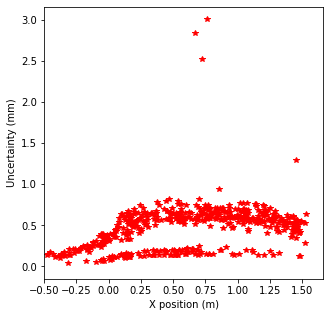

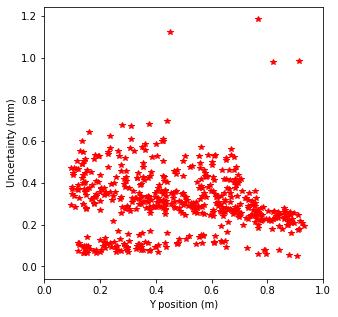

In [80]:
newfig(5,5)
plt.plot(poses[:,0],posuncert[:,0]*1e3,'*r')
plt.xlim([-0.5,w])
plt.xlabel('X position (m)')
plt.ylabel('Uncertainty (mm)')
# plt.ylim([-0.5,h])
newfig(5,5)
plt.plot(poses[:,1],posuncert[:,1]*1e3,'*r')
plt.xlim([0,1])
plt.xlabel('Y position (m)')
plt.ylabel('Uncertainty (mm)')

In [54]:
# from matplotlib.widgets import Slider
def redraw(t=0, window=10):
    plt.figure(figsize=(10,10))
    plt.vlines([0,w],0,h,'k')
    plt.hlines([0,h],0,w,'k')
    ix = np.argmax(time>t)
    a = 1
    while ix > 0 and a> 0.1:
        poss = poses[ix:ix+window+1] 
        plt.plot(poss[:,0], poss[:,1], alpha=a, linewidth=4, color = '#4b0082')
        ix-=window
        a*=0.9
    bw = 0.25
    plt.xlim([-bw,w+bw])
    plt.ylim([-bw,h+bw])
    plt.gca().set_aspect(1)

ts = time[0]    
btn=widgets.Button(description='reset t range')

intr = interactive(redraw, t=(ts,time[-1]), window=(0,50))
# def reset(*args):
#     tslide = intr.children[0]
#     tslide.min=tslide.value
#     tslide.max=tslide.value+50
# btn.on_click(reset)
display(btn,intr)

Button(description='reset t range', style=ButtonStyle())

interactive(children=(FloatSlider(value=67.82755102040817, description='t', max=201.32628684807256, min=67.827…

In [17]:
# from matplotlib.widgets import Slider
from matplotlib.patches import Ellipse
def redraw(t=0, window=10):
    plt.figure(figsize=(20,20))
    ax = plt.gca()
    plt.vlines([0,w],0,h,'k')
    plt.hlines([0,h],0,w,'k')
    st = np.argmax(time>t)
    ix=window
    a = 1
    while ix+window > 0:
        poss = poses[ix+st]
        art = Ellipse(poss,2*posuncert[ix+st,0],2*posuncert[ix+st,1], alpha=a, color = '#4b0082')
        ax.add_artist(art)
#         plt.plot(poss[:,0], poss[:,1], alpha=a, linewidth=4, color = '#4b0082')
        ix-=1
        a*=10**(-1/window)
    bw = 0.25
    plt.xlim([-bw,w+bw])
    plt.ylim([-bw,h+bw])
    plt.gca().set_aspect(1)

ts = time[0]    
btn=widgets.Button(description='reset t range')

intr = interactive(redraw, t=(ts,time[-1]), window=(0,500))
# def reset(*args):
#     tslide = intr.children[0]
#     tslide.min=tslide.value
#     tslide.max=tslide.value+50
# btn.on_click(reset)
display(btn,intr)

Button(description='reset t range', style=ButtonStyle())

interactive(children=(FloatSlider(value=67.94116213151928, description='t', max=201.4429365079365, min=67.9411…

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


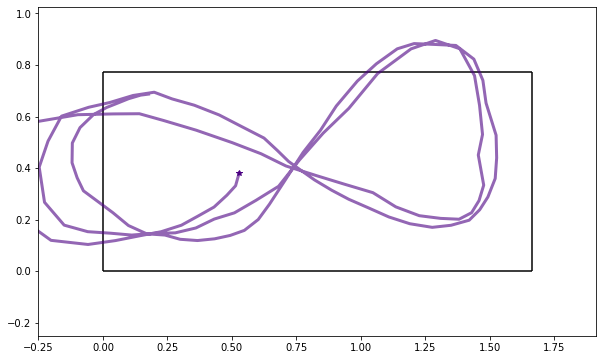

In [27]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
# plt.style.use('seaborn-pastel')
ts = 93
# ts=170
fr=4#hz
pts = 10
fig = plt.figure(figsize=(10,20))
bw = 0.25
ax = plt.axes(ylim=[-bw,h+bw], xlim=[-bw,w+bw])
ax.vlines([0,w],0,h,'k')
ax.hlines([0,h],0,w,'k')
ax.set_aspect(1)
artists = []
# for w in range(pts):
#     art = plt.Circle([],[])
#     ax.add_artist(art)
line, = ax.plot([], [], '*', lw=10, color = '#4b0082')
line2, = ax.plot([], [], lw=3, color = '#4b0082', alpha=0.6)

def init():
    line.set_data([],[])
    line2.set_data([],[])
    return line,line2,

def animate(i):
#     if i > 126:
#         i = 126
    t = ts + i/fr
    ix = 0

    ixs = np.logical_and(time > t, time < t+1/fr)
    x = poses[ixs,0]
    y = poses[ixs,1]
    line.set_data(x, y)
    ixs2 = np.logical_and(time > max(ts, t-30), time < t+1/fr)
    x2 = poses[ixs2,0]
    y2 = poses[ixs2,1]
    line2.set_data(x2, y2)
    return line,line2,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=124, interval=125, blit=True)


anim.save('fig8.gif', writer='ffmpeg')

In [234]:
def rot(pos, theta):
    return np.matmul(np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]),pos)

def d_from_theta(r2,dt,q1=0):
    #assumes mic1 to be at origin
    ct = 343*dt
    num = (r2**2-ct**2)
    den = 2*ct+2*r2*np.cos(q1)
    d1 = np.nan if den == 0 else num/den
    return d1 if d1 >= 0 else np.nan

def pos_from_theta(mic_pair,dt,theta):
    #mic0 as ref
    r = norm([mic_pair[1][0]-mic_pair[0][0],mic_pair[1][1]-mic_pair[0][1]])
    d = d_from_theta(r,dt,theta)
    s = cart(d,theta)
    phi = np.arctan2(mic_pair[1][1]-mic_pair[0][1],mic_pair[1][0]-mic_pair[0][0])
    pos = rot(s,phi) + np.array(mic_pair[0])
    return pos

In [214]:


rot((1,0), np.pi/2)

array([6.123234e-17, 1.000000e+00])

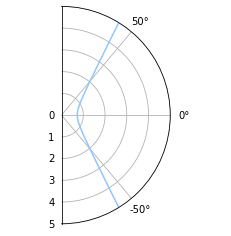

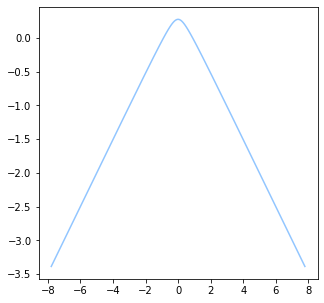

In [242]:
r = []

thetas = np.linspace(-np.pi/2, np.pi/2)
ps = np.zeros((thetas.shape[0],2))
for ix, theta in enumerate(thetas):
    ps[ix] = pos_from_theta(((0,1),(0,0)), -0.0013,theta)
    r.append(d_from_theta(1,-0.0013,theta))
plt.polar(thetas,r)
plt.xlim([-np.pi/2, np.pi/2])
plt.ylim(0,5)
newfig(5,5)
plt.plot(ps[:,0], ps[:,1])

In [176]:
def duncert(xm,ym,xa,ya,xb,yb,sigma_pos):
    dx1 = lambda x1,y1,x2,y2,xs,ys: -(2*x1 - 2*xs)/(686*((x1 - xs)**2 + (y1 - ys)**2)**(1/2))
    dy1 = lambda x1,y1,x2,y2,xs,ys: -(2*y1 - 2*ys)/(686*((x1 - xs)**2 + (y1 - ys)**2)**(1/2))
    dx2 = lambda x1,y1,x2,y2,xs,ys: (2*x2 - 2*xs)/(686*((x2 - xs)**2 + (y2 - ys)**2)**(1/2))
    dy2 = lambda x1,y1,x2,y2,xs,ys: (2*y2 - 2*ys)/(686*((x2 - xs)**2 + (y2 - ys)**2)**(1/2))
    (xa,ya,xb,yb,xm,ym)
    unc = norm([dx1(xa,ya,xb,yb,xm,ym)*sigma_pos, dy1(xa,ya,xb,yb,xm,ym)*sigma_pos,
                  dx2(xa,ya,xb,yb,xm,ym)*sigma_pos, dy2(xa,ya,xb,yb,xm,ym)*sigma_pos])
    return unc

def d_from_theta(r2,dt,q1=0):
    #assumes mic1 to be at origin
    ct = 343*dt
    num = (r2**2-ct**2)
    den = 2*ct+2*r2*np.cos(q1)
    d1 = np.nan if den == 0 else num/den
    return d1 if d1 >= 0 else np.nan

def rot(pos, theta):
    return np.matmul(np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]),pos)

In [178]:
rscale = 1000
mics = ([0,h],[0,0],[w,h],[w,0])
x_range,xstep = np.linspace(0,w,int(100*w),retstep=True)
y_range,ystep = np.linspace(0,h,int(100*h),retstep=True)
X,Y = np.meshgrid(x_range,y_range)
jpdf = np.zeros(X.shape)
print(X.shape)
individual = [np.zeros(X.shape) for k in range(6)]

ind = 0
for a in range(len(mics)-1):
    for b in range(a+1,len(mics)):
        for ix,x in enumerate(x_range):
            for iy, y in enumerate(y_range):
                pos = np.array([x,y])
                dt_meas = times[0,b] - times[0,a]
                dt_calc = tdoa(pos, (mics[a],mics[b]))
#                 ut = norm((uncert[0,b], uncert[0,a], duncert(x,y,mics[a][0], mics[a][1],mics[b][0],mics[b][1],0.01)))
                ut = duncert(x,y,mics[a][0], mics[a][1],mics[b][0],mics[b][1],0.01)
                p = np.exp(((dt_meas-dt_calc/ut)**2)*(-1/2))
                individual[ind][iy,ix] = p
        ind+=1


(77, 166)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


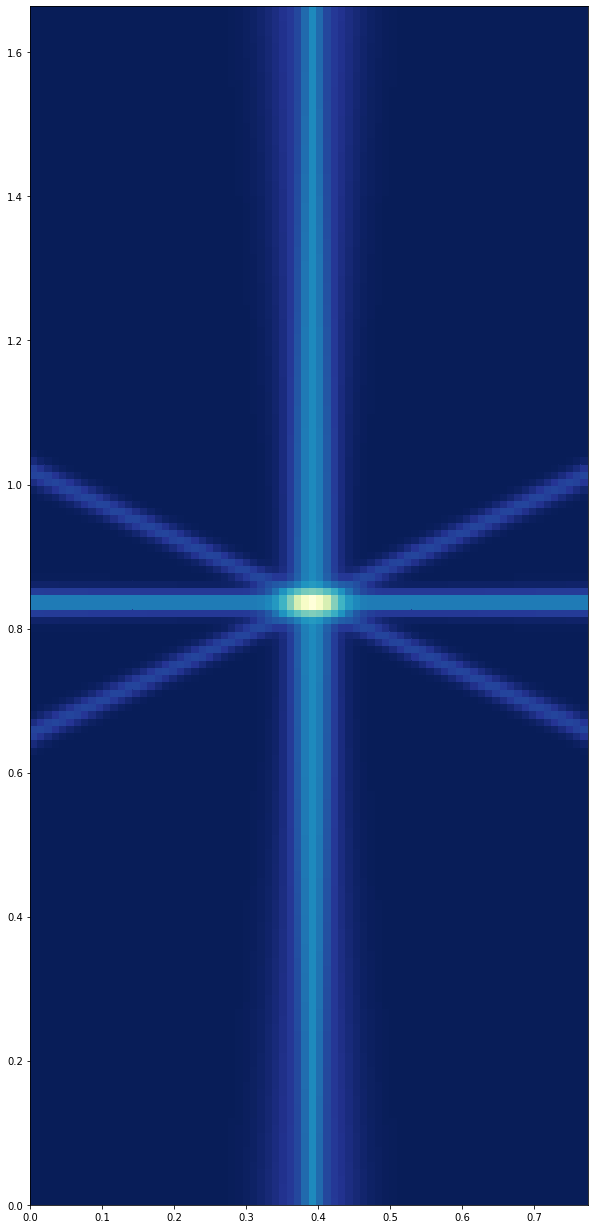

In [151]:
jpdf = np.nansum(individual,0)/6
plt.figure(figsize=(10,40))
plt.pcolor(Y,X,jpdf, cmap='YlGnBu_r')
plt.gca().set_aspect(1)

In [188]:
X,Y = np.meshgrid(x_range,y_range)
def f(t):
    print(t)
    res = 100
    mics = ([0,h],[0,0],[w,h],[w,0])
    x_range,xstep = np.linspace(0.001,w,int(res*w),retstep=True)
    y_range,ystep = np.linspace(0.001,h,int(res*h),retstep=True)
    jpdf = np.zeros(X.shape)
#     print(X.shape)
    individual = [np.zeros(X.shape) for k in range(6)]
    ind = 0
    for a in range(len(mics)-1):
        for b in range(a+1,len(mics)):
#             ut = norm((uncert[t,b], uncert[t,a]))
            
            dt_meas = times[t,b] - times[t,a]
            for ix,x in enumerate(x_range):
                for iy, y in enumerate(y_range):
                    ut = duncert(x,y,mics[a][0], mics[a][1],mics[b][0],mics[b][1],0.05)
                    pos = np.array([x,y])
                    dt_calc = tdoa(pos, (mics[a],mics[b]))
                    p = np.exp(((dt_meas-dt_calc)/ut)**2*(-1/2))
                    individual[ind][iy,ix] = p
            ind+=1
    jpdf = np.sum(individual,0)
    plt.figure(figsize=(10,40))
    plt.pcolor(Y,X,jpdf, cmap='YlGnBu_r')
    plt.gca().set_aspect(1)
    amax = np.argmax(jpdf)
    (xi,yi) = np.unravel_index(amax,jpdf.shape)
    return (xi*xstep,yi*ystep)
#     print("max at: ", xi*xstep,yi*ystep)
interactive(f,t=(0,times.shape[0]))


interactive(children=(IntSlider(value=268, description='t', max=536), Output()), _dom_classes=('widget-interac…

In [189]:
poses2 = np.zeros(poses.shape)
for t in range(times.shape[0]):
    poses2[t] = f(t)
    

0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


1
2
3
4
5
6


KeyboardInterrupt: 

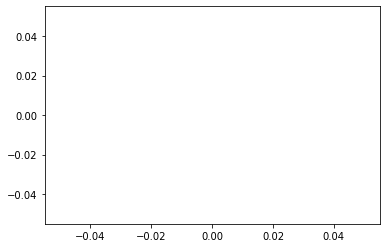

In [185]:
plt.plot(poses2[:,0], poses2[:,1])

In [187]:
poses2

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])